### Imports

In [85]:
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.visualization as vis
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from os.path import *
import pandas as pd
import shutil
import time
import voi_methods as vm
import skimage.measure
from math import floor, ceil
import re
import scipy.ndimage.morphology
import operator
import csv
%matplotlib inline

In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config("etiology")

for sheet in C.sheetnames:
    src_data_df = pd.read_excel(C.xls_name, sheet)
    a = []
    for _, row in src_data_df.iterrows():
        a.append(row["z2"] - row["z1"])
    print(np.median(a) / C.lesion_ratio)

# Generate data

In [4]:
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
input_df = pd.read_excel(accnum_xls_path, sheetname="Prelim Analysis Patients", index_col=0, parse_cols="A,J")

hcv_accnums = list(input_df[input_df["Category"] == "HCV"].index.astype(str))
hbv_accnums = list(input_df[input_df["Category"] == "HBV"].index.astype(str))
nv_accnums = list(input_df[input_df["Category"] == "Nonviral"].index.astype(str))

In [61]:
cls_num=0
cls = C.cls_names[0]
accnum = '1025886'#hcv_accnums[1]
load_dir = join(C.dcm_dirs[cls_num], accnum)

In [59]:
print(load_dir)

D:\Etiology\Imaging\1003071


In [ ]:
importlib.reload(hf)
accnum = hcv_accnums[0]
load_dir = join(C.dcm_dirs[cls_num], accnum)
art,D = hf.dcm_load_special(join(load_dir, C.phases[0]), True, True, False)
ven,D = hf.dcm_load_special(join(load_dir, C.phases[1]), True, True, False)
equ,D = hf.dcm_load_special(join(load_dir, C.phases[2]), True, True, False)
vis.draw_slices(I)

In [125]:
nii_path = "D:\\tmp.nii.gz"
hf.save_nii(np.stack([art, ven, equ],-1), nii_path, D)

In [91]:
os.listdir(join(load_dir, 'Segs'))

['Capture.JPG', 'Liver-NN.off', 'Tumor', 'tumor_20s.off']

In [ ]:
masks.off2ids(join(load_dir, 'Segs', 'tumor_20s'))

In [93]:
print(join(load_dir, 'Segs', 'tumor_20s'))

D:\Etiology\Imaging\1002857\Segs\tumor_20s


In [126]:
img,D = hf.nii_load(nii_path)

In [120]:
mask_path = join(load_dir, 'Segs', 'tumor_20s')
mask,_ = masks.get_mask(mask_path, D, img.shape[:3])

In [115]:
mask,_ = masks.get_mask(mask_path, D, img.shape[:3])

In [320]:
with open(off_path, 'r') as f:
    A = np.array([x.split(' ') for x in f.readlines()[2:]])
    V = np.array([list(map(float,a)) for a in A if len(a) == 3])
    F = np.array([list(map(int,a[1:])) for a in A if len(a) == 4])
    del A

V = split_vertices(V, F)

for ix, A in enumerate(V):
    mins = A.min(0)
    maxes = A.max(0)

    G = np.zeros([math.ceil(maxes[i])-math.floor(mins[i])+1 for i in range(3)], bool)

    O = [math.floor(x) for x in mins]

    A -= O

    for vert in A:
        G[[slice(int(round(x)), int(round(x))+1, None) for x in vert]] = 1

    B=np.zeros((3,3,1))
    B[:,1] = 1
    B[1,:] = 1
    G = scipy.ndimage.morphology.binary_fill_holes(G, structure=B)

    masks.save_mask(G, save_path+"_%d" % ix, vox_scales=[1]*3, save_mesh=False, origin=O)

In [360]:
hf.create_dicom(G, "D:\\test", True)

In [382]:
importlib.reload(masks)
masks.create_dcm_with_mask(join(load_dir, C.phases[0]), "D:\\tmp", "D:\\test", overwrite=True)

Call shutil.rmtree on C:\Users\Clinton\AppData\Local\Temp\tmp1e0fgk12


In [372]:
M = masks.get_mask("D:\\tmp")

In [378]:
img,D = hf.load_img(join(load_dir, C.phases[0]))

Call shutil.rmtree on C:\Users\Clinton\AppData\Local\Temp\tmpmget6we0


In [131]:
importlib.reload(masks)
M = masks.get_mask(join(load_dir, 'Segs', 'tumor_20s.ids'), D, img.shape)

In [132]:
masks.get_mask_disjoint_vols(join(load_dir, 'Segs', 'tumor_20s.ids'))

[4601.809243070999, 109.006020412]

In [129]:

for fn in glob.glob(join(load_dir, 'Segs', 'tumor_20s_*.ids')):
    M = masks.crop_img_to_mask_vicinity(nii_path, fn[:-4])
    break

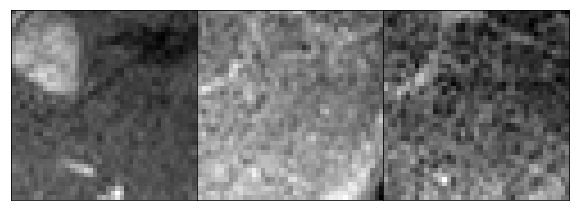

In [130]:
vis.draw_slices(M)

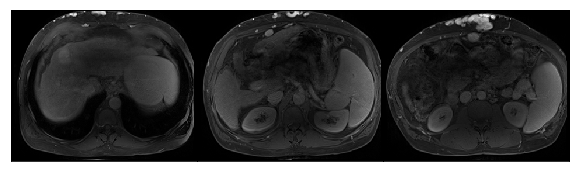

In [82]:
importlib.reload(hf)
accnum = '1025886'
load_dir = join(C.dcm_dirs[cls_num], accnum)
I,D = hf.dcm_load_special(join(load_dir, C.phases[0]), True, True, False)
vis.draw_slices(I)

In [ ]:
drm.report_missing_folders()

In [5]:
a = hf.load_dcm_header(r"Z:\Paula\E101686218\ax lava dynaplan bh autovoice_10")

In [58]:
df = pd.read_excel(C.xls_name, "HCC")

In [37]:
importlib.reload(hf)
hf.split_dcm(r"Z:\Paula\Imaging\E105160323\T1_multiphase")

In [61]:
importlib.reload(drm)
drm.report_missing_folders()#cls="adenoma")

In [33]:
def sort_by_series_num(arr):
    return sorted(arr, key=lambda x: int(x[x.rfind("_")+1:]))

def semiauto_rename_phases(lesion_dir):
    for accnum in glob.glob(join(lesion_dir, "*")):
        fnames = [join(accnum, x) for x in ["T1_BL", "T1_AP", "T1_VP", "T1_EQ"]]
        if np.all([exists(fnames[i]) for i in range(len(fnames))]):
            continue

        PRE = [x for x in os.listdir(accnum) if "pre" in x] #("vibe" in x or "axial abd" in x) and 
        if len(PRE) > 1:
            PRE = [x for x in PRE if "reg" in x]

        DCE = [x for x in os.listdir(accnum) if ("vibe" in x or "dynamic" in x) and "post" in x and "sub" not in x]
        if len(DCE) > 0:
            DCE = sort_by_series_num([x for x in DCE if "min" not in x])
        else:
            DCE = [x for x in os.listdir(accnum) if "art" in x and "reg" in x] + \
                    [x for x in os.listdir(accnum) if ("port" in x or "pv" in x) and "reg" in x] + \
                    [x for x in os.listdir(accnum) if "equ" in x and "reg" in x]
        if len(DCE) == 0:
            DCE = [x for x in os.listdir(accnum) if "ART" in x] + \
                    [x for x in os.listdir(accnum) if "PV" in x] + \
                    [x for x in os.listdir(accnum) if "DL" in x]
        if len(DCE) < 3: #len(PRE) == 0 or 
            continue

        print(accnum, DCE[0], DCE[1], DCE[2], sep="\n") #sort_by_series_num(PRE)[-1], 
        correct = input()
        if correct == "0":
            #os.rename(join(accnum, PRE[0]), join(accnum, "T1_BL"))
            os.rename(join(accnum, DCE[0]), join(accnum, "T1_AP"))
            os.rename(join(accnum, DCE[1]), join(accnum, "T1_VP"))
            os.rename(join(accnum, DCE[2]), join(accnum, "T1_EQ"))
        elif correct == "q":
            return
        else:
            continue

In [15]:
join(C.img_dirs[0], '13216353', 'T1_multiphase')

'Z:\\Paula\\13216353\\T1_multiphase'

In [17]:
head = hf.load_dcm_header(join(C.img_dirs[0], '13216353', 'T1_multiphase'))

In [31]:
importlib.reload(drm)
drm.dcm2npy_batch(acc_nums=['E102088195'], overwrite=True)#cls="adenoma", acc_nums=['E100693392'], overwrite=True)

In [ ]:
drm.load_patient_info()#'hcc', acc_nums=['E100398240'], overwrite=False)

In [95]:
importlib.reload(drm)
drm.load_vois_batch("hcc", ["E101779513"], overwrite=True)#acc_nums=["E101686218", "E106120112", "E102256903", "E104476566", "E105228237"], overwrite=True)

In [3]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [74]:
voi_df_art[(voi_df_art["real_dz"] <= 0) | (voi_df_art["real_dy"] <= 0) | (voi_df_art["real_dx"] <= 0)]

,acc_num,x1,x2,y1,y2,z1,z2,cls,real_dx,real_dy,real_dz,run_num


In [12]:
importlib.reload(vm)
[vm.reset_accnum(x) for x in ["12807018"]]

.

[None]

vm.reload_accnum('hcc', ['E100793044', '13216353', 'E101892543', '13278054', 'E101779513', 'E101686218'], augment=True, overwrite=True)

In [139]:
importlib.reload(vm)
vm.extract_vois("hcc", ["E101892543"])

.

In [100]:
small_voi_df = pd.read_csv(C.small_voi_path)
small_voi_df[small_voi_df["acc_num"] == "E101779513"]

In [4]:
importlib.reload(vm)
#vm.extract_vois()#cls="abscess")
vm.save_unaugmented_set()
vm.save_augmented_set()
#vm.parallel_augment(num_cores=3)#, overwrite=100)

hcc 678.7057266235352
non-hcc 491.1044969558716


In [ ]:
importlib.reload(vm)
vm.xref_dirs_with_excel()

In [15]:
for d in glob.glob(join("E:\\for_charlie\\small", "*")):
    dd=basename(d)
    os.rename(d, join(dirname(d), prv.encode(dd[:dd.find('_')])+dd[dd.find('_'):]))

In [3]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

In [5]:
importlib.reload(vm)
vm.save_vois_as_imgs(lesion_ids=Z_reader, save_dir="E:\\Reader study", separate_by_cls=True)

In [ ]:
vm.save_vois_as_imgs(save_dir="D:\\Paula-project\\screenshots\\small", separate_by_cls=True)
vm.save_imgs_with_bbox(save_dir="D:\\Paula-project\\screenshots\\large", separate_by_cls=True)

In [ ]:
voi_df_art[voi_df_art['id'].str.contains('2424_2')]
#voi_df_art[voi_df_art.index.str.contains('9185_0')]

In [109]:
d=[]
for i in range(6):
    df = pd.read_excel('Z:\\Prototype1e.xlsx', sheetname=C.sheetnames[i])
    d.append(df[df['Run'] <= 2]['Diameter'].values)
d = np.concatenate(d)
np.std(d)

# Plotting

In [12]:
Z = ["12569826_2", "E103354676_1", "E100459207_2", "13010227_0", "13003974_0", "12874178_0"]

In [ ]:
vm.save_imgs_with_bbox(Z)

In [29]:
drm.dcm2npy_batch(acc_nums=["13216353"], overwrite=True)

In [37]:
vm.reset_accnum("13216353")

.

In [3]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [11]:
voi_df_art[voi_df_art["acc_num"].str.startswith("1287")]

,acc_num,x1,x2,y1,y2,z1,z2,cls,real_dx,real_dy,real_dz,run_num
12874178_0,12874178,49,80,81,109,44,65,hemangioma,45.208335,40.833334,63.0,1
12874178_1,12874178,70,80,81,94,17,24,hemangioma,14.583334,18.958334,21.0,1
12874178_2,12874178,73,85,86,97,78,86,hemangioma,17.500000,16.041667,24.0,1
12874178_3,12874178,90,104,69,80,73,81,hemangioma,20.416667,16.041667,24.0,1


In [ ]:
importlib.reload(drm)
cls = "hcc"
acc_num = 'E103301795'
img = np.load(C.full_img_dir+"\\"+cls + "\\"+acc_num + ".npy")
vis.draw_flipped_slices(img, voi_df_art[(voi_df_art["acc_num"] == acc_num) & (voi_df_art["cls"] == cls)].iloc[0])
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

In [61]:
importlib.reload(vm)
[vm.reset_accnum(x[:-2]) for x in ['13010227_0', 'E105993177_0',
 'E100852770_0', 'E103835733_0', '12888679_0', 'E100458776_0', 'E100894274_0']]

.......

[None, None, None, None, None, None, None]

-0.9749059606481485 0.9052014807754605 -0.0664152584179922


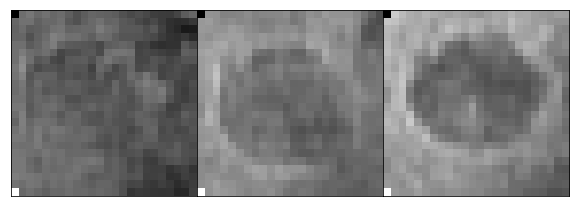

In [38]:
importlib.reload(vm)
img = vm.plot_check(2, "13216353", normalize=[-1,1])
print(np.amin(img), np.amax(img), np.mean(img))

In [ ]:
for cls in C.classes_to_include:
    print(cls)
    print('\n'.join([x[:-4] for x in os.listdir("E:\\lesion_imgs_small\\"+cls)]))
    #vm.save_vois_as_imgs(cls=cls, save_dir="E:\\lesion_imgs_small\\"+cls, fn_suffix="")

In [294]:
lids = ['E106097391_0.npy', 'E104978772_1.npy', '12900535_0.npy', 'E100150242_0.npy', 'E105490014_0.npy', 'E103147618_0.npy', 'E103510187_0.npy', 'E104657225_0.npy', 'E100551966_0.npy', 'E101388602_0.npy', 'E100215900_8.npy', 'E100215900_7.npy', 'E104045692_0.npy', '13104521_0.npy', 'E100383453_0.npy', '12943286_0.npy', '12271995_0.npy', 'E102315724_0.npy', 'E104949189_0.npy', 'E100511083_1.npy', 'E101579471_0.npy', '13018986_1.npy', '13203550_8.npy', '13112385_0.npy', '12712463_0.npy', '12361082_0.npy', '13028374_0.npy', 'E103985934_1.npy', 'E100529980_0.npy', '12042703_3.npy', '12961059_0.npy', 'E105724706_2.npy', 'E100592424_2.npy', 'E103104254_0.npy', 'E104546069_0.npy', 'E101665217_1.npy', '12090000_0.npy', 'E100592424_1.npy', '12961059_1.npy', 'E105474285_0.npy', '12502068_1.npy', 'E100814791_0.npy', 'E102613189_0.npy', 'E105427046_0.npy', 'E102881031_1.npy', 'E102929168_0.npy', 'E102310482_0.npy', 'E102095465_0.npy', 'E101811299_0.npy', 'E104737273_0.npy', '12890053_0.npy', 'E100168661_1.npy', '12637865_0.npy', 'E100168661_2.npy', '12239783_0.npy', '12707781_0.npy', '12706568_1.npy', '12823036_0.npy', '12404081_0.npy', '12365693_1.npy']

In [301]:
lids = ['13018986_1', '13203550_8', 'E100168661_1', '12706568_1', 'E104189184_0', 'E100215900_7', '12900535_0', 'E100551966_0',
       'E102310482_0', 'E102095465_0', 'E105474285_0', 'E105724706_2']

In [32]:
misclass_img = ['E100610622_0', '12788616_0', '13092836_2', 'E100407633_0', 'E103312835_1', 'E103020139_1']

In [ ]:
vm.save_imgs_with_bbox(lesion_ids=misclass_img, save_dir="E:\\Z_test", separate_by_cls=False)

In [8]:
importlib.reload(vm)
save_dir = "D:\\Paula-project\\screenshots"
#save_dir = "E:\\lesion_imgs_small"
vm.save_vois_as_imgs(save_dir=save_dir, separate_by_cls=True, normalize=[-1,1])

# Generate reader study samples

In [24]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [120]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

banned_accnums = [z[:z.find('_')] for z in Z_reader]

voi_reader = voi_df_art[voi_df_art["id"].isin(Z_reader)]#voi_df_art[voi_df_art.index.isin(Z_reader)]

In [260]:
f_map = {}
b_map = {}
cls_map = {}

for cls in C.classes_to_include:
    for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
        img_id = str(sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])
        acc_num = row["Filename"][:-4] #row["acc_num"]
        f_map[row["id"]] = img_id
        b_map[img_id] = row["id"]#acc_num
        cls_map[row["id"]] = row["cls"]#acc_num
        #if cls == "fnh":#img_id == "4613":
        print("Z:\\DICOMs\\" + cls + "\\" + acc_num, 
              row["x1"], row["x2"], row["y1"], row["z1"], "---", img_id)
        try:
            print(b_map[img_id])
        except:
            pass

#f_map['E100199185'] = '46130'
#b_map['4613'] = "12678910_1"
#b_map['46130'] = "E100199185_0"

In [262]:
with open('Z:\\answer_key.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for k in Z_reader:
        writer.writerow([k, f_map[k], cls_map[k]])

In [ ]:
hitlist = []
replacements = []

for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047'] + ['4354', '3049', '5438'] + ['46130']:#['4158', '5720', '46130', '7444']:
    print(cls_map[b_map[secret_id]])
    hitlist.append(b_map[secret_id])
    replacements.append(cls_map[b_map[secret_id]])

In [165]:
for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047']:
    base_dir = r"Z:\Inter-reader study\DICOMs"
    shutil.move(os.path.join(base_dir, secret_id), os.path.join(base_dir, "Unused", secret_id))

In [33]:
multi_accnums = [accnum for accnum, count in zip(*np.unique(list(b_map.values()), return_counts=True)) if count>1]
print(multi_accnums)

In [276]:
for _, row in voi_reader.iterrows():
    cls = row["cls"]
    acc_num = str(row["Filename"])[:-4]
    for protocol in ["T1_AP", "T1_VP", "T1_EQ"]:
        target_dir = os.path.join("Z:\\Inter-reader study\\DICOMs\\extras", row['id'], protocol)
        shutil.copytree(os.path.join("Z:\\DICOMs", cls, acc_num, protocol), target_dir)

In [ ]:
for acc_num in f_map:
    try:
        os.rename(os.path.join("Z:\\Inter-reader study\\DICOMs", acc_num),
                  os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num]))
    except Exception as e:
        print(acc_num, e)

# Read Run Stats

In [64]:
a = ['E106158268_0','E102424706_0','12570256_0','E100574689_0','E106120112_0','E100899012_0','E103678771_0','E105095742_0','E100899012_1','13278054_0','E100834987_0','13094833_0','E102088195_1','E101554830_0','12801670_0','E100304876_1','13013150_0','12807018_0','E101449797_0','12249331_0','E101686218_0','12993437_1','E101158768_0','E101356604_0','E105124678_0','12993437_0','E100793044_0','E104587275_0','E104099161_0','E105152299_0','E102031795_1','E100623842_0','E102388865_0','E103301795_0','E100814791_0','13160747_0','E101880575_0','12248774_1','12914169_0','E101442376_0','13197011_0']

In [66]:
vm.save_vois_as_imgs(save_dir=r"Z:\Paula\Screenshots")

In [25]:
import cnn_builder as cbuild
A = cbuild._collect_unaug_data()

Using TensorFlow backend.


In [ ]:
df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
mis_test += df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
sorted_x

In [ ]:
for z in sorted_x:
    print(z[0],'\t',z[1])

In [18]:
vm.save_vois_as_imgs(lesion_ids=[k for k in x if x[k]>2 and k!=""], save_dir="Z:\\Paula\\Misclassifications", separate_by_cls=True, normalize=[-1,1])

df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] < 1515879326)]

In [15]:
df = pd.read_csv(C.run_stats_path)

In [17]:
print(C.run_stats_path)

D:\Paula-project\data\overnight_run.csv


In [33]:
train_acc = [1-x.count("_")/140 for x in df['misclassified_train'].values] #434

In [4]:
cms = df['confusion_matrix'].values
cms = ''.join(cms)

supercm = hf.str_to_lists(cms, dtype=int)
supercm = [supercm[rownum:rownum+C.nb_classes] for rownum in range(0,len(supercm),C.nb_classes)]
supercm = np.array(supercm)

cm_sum = np.empty((C.nb_classes,C.nb_classes))

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        print(cm_sum[j,i],end='\t')
    print()

695.0	135.0	
55.0	615.0	


In [7]:
np.sum(cm_sum[0,:])

750.0

In [12]:
avg_tpr = cm_sum[0,0]/np.sum(cm_sum[0,:])
avg_fpr = np.sum(cm_sum[1:,0])/np.sum(cm_sum[1:,:])

In [7]:
fpr = [np.sum(cm[1:,0])/np.sum(cm[1:,:]) for cm in supercm]
tpr = [cm[0,0]/np.sum(cm[0,:]) for cm in supercm]

In [5]:
test_num = 10
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+test_num] for rownum in range(0,len(predictions),test_num)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(len(df)):
    for lesion_num in range(test_num):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+1e-6] = 'hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+1e-6] = 'non-hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

In [190]:
true = len(thresh_dict)//2
false = len(thresh_dict)//2
TPR = [true/true]
FPR = [false/false]
a=0
hcc_correct = len(thresh_dict)//2
hcc_wrong = len(thresh_dict)//2
for key in sorted(thresh_dict):
    if key > minT[1]:
        break
    if key > minT[0]:
        a+=1
        if thresh_dict[key] != 'hcc':
            hcc_wrong -= 1
    elif thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/true)
    FPR.append(hcc_wrong/false)

In [189]:
minT=[.68,.99]

In [191]:
R = (1-FPR[-1], TPR[-1])
R

(0.9, 0.9)

In [186]:
a/len(thresh_dict)

0.6206666666666667

In [180]:
hcc_fpos_cost = 12000
hcc_miss_cost = 5000
biopsy_cost = 1400

In [81]:
nonhcc_thresh = np.array(nonhcc_thresh)
hcc_thresh = np.array(hcc_thresh)
all_thresh = np.array(list(thresh_dict.keys()))

In [178]:
(hcc_thresh < minT[0]).sum()

11

In [183]:
(nonhcc_thresh > minT[1]).sum()

0

In [200]:
true_spec = (nonhcc_thresh < minT[0]).sum() / (750 - ((nonhcc_thresh < minT[1]) & (nonhcc_thresh > minT[0])).sum())
true_sens = (hcc_thresh > minT[1]).sum() / (750 - ((hcc_thresh < minT[1]) & (hcc_thresh > minT[0])).sum())
true_spec, true_sens

(1.0, 0.0)

In [155]:
fun = lambda T: hcc_fpos_cost * (nonhcc_thresh > T[1]).sum() + hcc_miss_cost * (hcc_thresh < T[0]).sum() + \
        biopsy_cost * ((all_thresh < T[1]) & (all_thresh > T[0])).sum()

In [165]:
import math

In [198]:
minC=1e10
for T1 in np.linspace(0,1,100,False):
    for T2 in np.linspace(T1,1,(1-T1)*100+1):
        C = fun([T1,T2])
        if minC > C:
            minC = C
            minT = [T1,T2]

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:
minC

1028000

In [199]:
minT

[0.03, 1.0]

In [93]:
scipy.optimize.basinhopping(fun, [0,1], T=.1)

                        fun: 1234000
 lowest_optimization_result:       fun: 1234000
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.50207778, 0.44547252])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 428
                        nit: 100
                       njev: 107
                          x: array([0.50207778, 0.44547252])

In [62]:
rates05, (avg_fpr, avg_tpr), rates95

((0.25066666666666665, 0.9786666666666667),
 (0.18, 0.9266666666666666),
 (0.12533333333333332, 0.7893333333333333))

In [13]:
avg_fpr, avg_tpr

(0.18, 0.9266666666666666)

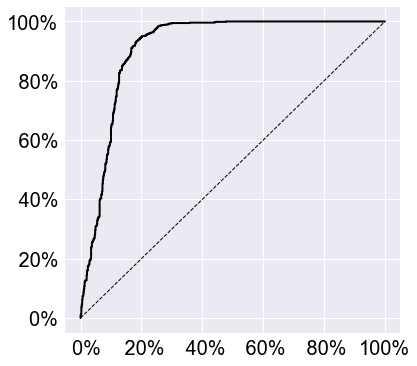

In [6]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(FPR, TPR, 'k', label='Model', linewidth=2)
#ax.plot(.04, 1, 'ko', label='ModelReader', markersize=12)
#ax.plot(0, .7, 'k^', label='RAD2', markersize=12)
#ax.plot(0, .6, 'k ^', label='RAD1', markersize=12)
#ax.plot(avg_fpr, avg_tpr, 'ko', label='ModelAvg', markersize=10)
#ax.plot(rates10[0], rates10[1], 'ko', label='10%', markersize=10)
#ax.plot(rates95[0], rates95[1], 'ko', label='90%', markersize=10)
#ax.plot(rates05[0], rates05[1], 'ko', label='5%', markersize=10)
#ax.plot(rates98[0], rates98[1], 'ko', label='95%', markersize=10)
#ax.plot(fpr, tpr, 'o', ms=5)
ax.plot([0,1], [0,1], 'k--', lw=1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')

#ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
#ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

In [56]:
sp.plot(FPR, TPR, 'k', label='Model', linewidth=3)
sp.plot(.1, .9, 'g^', label='Model', markersize=10)
sp.plot(.43, 1., 'r^', label='R2', markersize=10)
sp.plot(.67, 1., 'b^', label='R1', markersize=10)

In [63]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

0.9124888888888876

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)

# Artificial images

In [ ]:
agm.gen_imgs()
img = agm.visualize_gen_img('hemangioma')